In [1]:
%load_ext lab_black
%matplotlib inline
from src.model_code.latin_hypercubes import optimal_latin_hypercube_sample
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Introduction

In the following, our implementation of Park's [(1994)](https://www.sciencedirect.com/science/article/abs/pii/0378375894901155) algorithm for finding optimal (midpoint) Latin hypercubes in Python is presented. Latin hypercube sampling or design (Lhd) is a sampling method that is very popular in the context of computer experiments. By dividing the distributions of the input variables into intervals of equal length and enforcing to draw one sample from each interval for each variable, this promises a more uniform distribution of sampling points than plain random sampling. In the two-dimensional case, this means each sampling point will lie in a square in the plane, and there will be no sampling point in a square that lies on the same row or column as another point's square.

While they are generally cheap to construct, their somewhat random generation can still leave some areas underrepresented, as the following example of a bad Latin hypercube demonstrates:

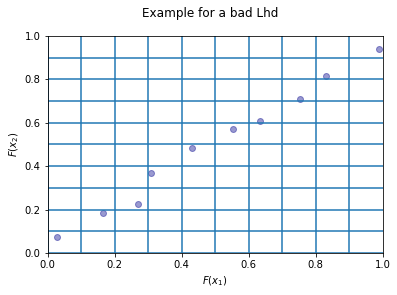

In [2]:
fig, ax = plt.subplots()
fig.suptitle("Example for a bad Lhd")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("$F(x_2)$")
ax.set_xlabel("$F(x_1)$")

n = 10

bad = np.array([[i / n, i / n] for i in range(n)])
bad += np.random.default_rng().uniform(size=bad.shape) / n

sns.regplot(
    x=bad[:, 0],
    y=bad[:, 1],
    ax=ax,
    fit_reg=False,
    color="darkblue",
    scatter_kws={"alpha": 0.4},
)

for i in np.arange(0, 1, 1 / n):
    plt.axhline(i)
    plt.axvline(i)

While this fulfills the requirements of a Latin hypercube design (each filled square is in its own row and column), there are visibly empty regions that have no sample points. The literature accordingly examined _optimal_ Latin hypercube designs (OLhds), which are designs that optimize some criterion function (often related to the covariance matrix), and found that these optimal designs are more efficient in the sense of yielding smaller prediction error. However, the optimization of the criterion functions can be computationally intensive so faster numerical algorithms have been devised to deal with this problem.

## Park's algorithm

The algorithm presented here is based on Park (1994). His algorithm consists of two stages: first to find an optimal _midpoint_ Latin hypercube (OMLhd), that is, a Latin hypercube that has its points in the center of their hypercube (or "cell"). And in the second stage, optimally vary the points within their assigned cells to further optimize the criterion function. While this method is not guaranteed to find the "true" OLhd because it first restricts itself to midpoint Lhds, it can be argued that for large enough sample sizes the volume of each cell becomes very small ($n^{-d}$ in the case of uniform distribution of the variables) and thus the distance between an MLhd and Lhd that fill the same cells (or have the same "structure") is negligible.

## Formalization

Let $(F_1, ..., F_d)$ be the distribution functions of the $d$ input variables $(X_1, ..., X_d)$, and $x_{i, j}$ be the i-th observation of the j-th variable. To design Latin hypercubes, we use the $n \times d$ matrices $P$ and $R$, the former of which consists of columns that are some permutation of the numbers from 1 to n. The $R$ matrix has as entries in the i-th row and j-th column $r_{i, j} \sim U(0, 1)$. When designing our Lhd, we determine $x_{i, j}$ as
\begin{equation}
x_{i, j} = F_j^{-1}(\frac{1}{n}(p_{i, j} - r_{i, j}))
\end{equation}
The term $p_{i, j}/n$ determines in which of the $n$ intervals $x_{i, j}$ is situated, so the row $i$ of the matrix $P$ determines the cell in which the i-th observation lands and the i-th row of the matrix $R$ determines _where_ in the cell the point lands. The first stage of the algorithm thus consists of finding 